In [37]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import motornet as mn

file_dir = sys.path[0]
sys.path.append(os.path.dirname(file_dir[:file_dir.rfind('tutorials')]))

%load_ext autoreload
%autoreload 2
print('\n')
print('tensorflow version: ' + tf.__version__)
print('numpy version: ' + np.__version__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


tensorflow version: 2.7.0
numpy version: 1.21.5


# I. Build a basic plant with muscles wrapped around the skeleton

First, let's create a skeleton and declare a muscle type.
Next, we will the pass these to the base class ```Plant``` to create a plant object.
Finally, we can build a muscle system around the skeleton by specifying each muscle one by one, using the `Plant` object's ```add_muscle``` method.
The ```add_muscle``` method requires at least two arguments:
 - ```path_fixation_body```     should be a list of *N* integers, with *N* the number of insertion points of that muscle. Each individual value *n* of that list indicates the bone that insertion point fixes onto. *0* always indicates the worldspace, meaning it is not fixed on a bone and so does not move with it. This allows creating "anchor points" for the plant.
 - ```path_coordinates```       should be a list of *N* lists, each of these lists containing *M* values - with *M* the dimensionality of the worldspace. The *n*th list contains the set of coordinates of the *n*th insertion point with respect to the origin of the bone it is fixated on, or of the worldspace if it is not fixated on a bone.

In the example below, we create 4 ReLu muscles connecting to the worldspace with their first fixation point, and to the point mass with their second fixation point.

The muscles are organized as a X-shape according to the illustration below.



![](img/pointmass.png)

In [81]:

skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle = mn.plants.muscles.ReluMuscle()
point_mass = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle, excitation_noise_sd=10**-4)

# PointMass skeletons only have one "bone", which is the point itself.
point_mass.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[2, 2], [0, 0]], name='UpRight', max_isometric_force=500)
point_mass.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-2, 2], [0, 0]], name='UpLeft', max_isometric_force=500)
point_mass.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[2, -2], [0, 0]], name='DownRight', max_isometric_force=500)
point_mass.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-2, -2], [0, 0]], name='DownLeft', max_isometric_force=500)





In [82]:


point_mass.print_muscle_wrappings()





MUSCLE NAME: UpRight
--------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[2.0, 2.0], [0.0, 0.0]]
max_isometric_force:  500


MUSCLE NAME: UpLeft
-------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-2.0, 2.0], [0.0, 0.0]]
max_isometric_force:  500


MUSCLE NAME: DownRight
----------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[2.0, -2.0], [0.0, 0.0]]
max_isometric_force:  500


MUSCLE NAME: DownLeft
---------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-2.0, -2.0], [0.0, 0.0]]
max_isometric_force:  500




In [49]:

self = point_mass
for m in range(self.n_muscles):
  ix = np.where(self._muscle_index == (m + 1))[0]
  n_points = len(ix)
  fb = self._path_fixation_body.squeeze()[ix]
  coords = [self._path_coordinates.squeeze()[:, k].tolist() for k in ix]
  name = self.muscle_name[m]
  for param, value in self.tobuild__muscle.items():
    print(param + ": ", value[m])
  print("\n")


L = []
for m in range(self.n_muscles):
  ix = np.where(self._muscle_index == (m + 1))[0]

  d = {
    "n_fixation_points": len(ix),
    "fixation body": self._path_fixation_body.squeeze()[ix],
    "coordinates": [self._path_coordinates.squeeze()[:, k].tolist() for k in ix],
    "name": self.muscle_name[m],
  }

  for param, value in self.tobuild__muscle.items():
    d[param] = value[m]
  L.append(d)




max_isometric_force:  500


max_isometric_force:  500


max_isometric_force:  500


max_isometric_force:  500





Using the muscle paths defined in the ```add_muscle``` method, the ```Plant``` class can then determine the moment of each muscle with respect to the joints it spans using geometric first principles. We can visualize this by plotting the moment of each muscle with respect to a dimension as a function of the position of the point mass in the workspace.


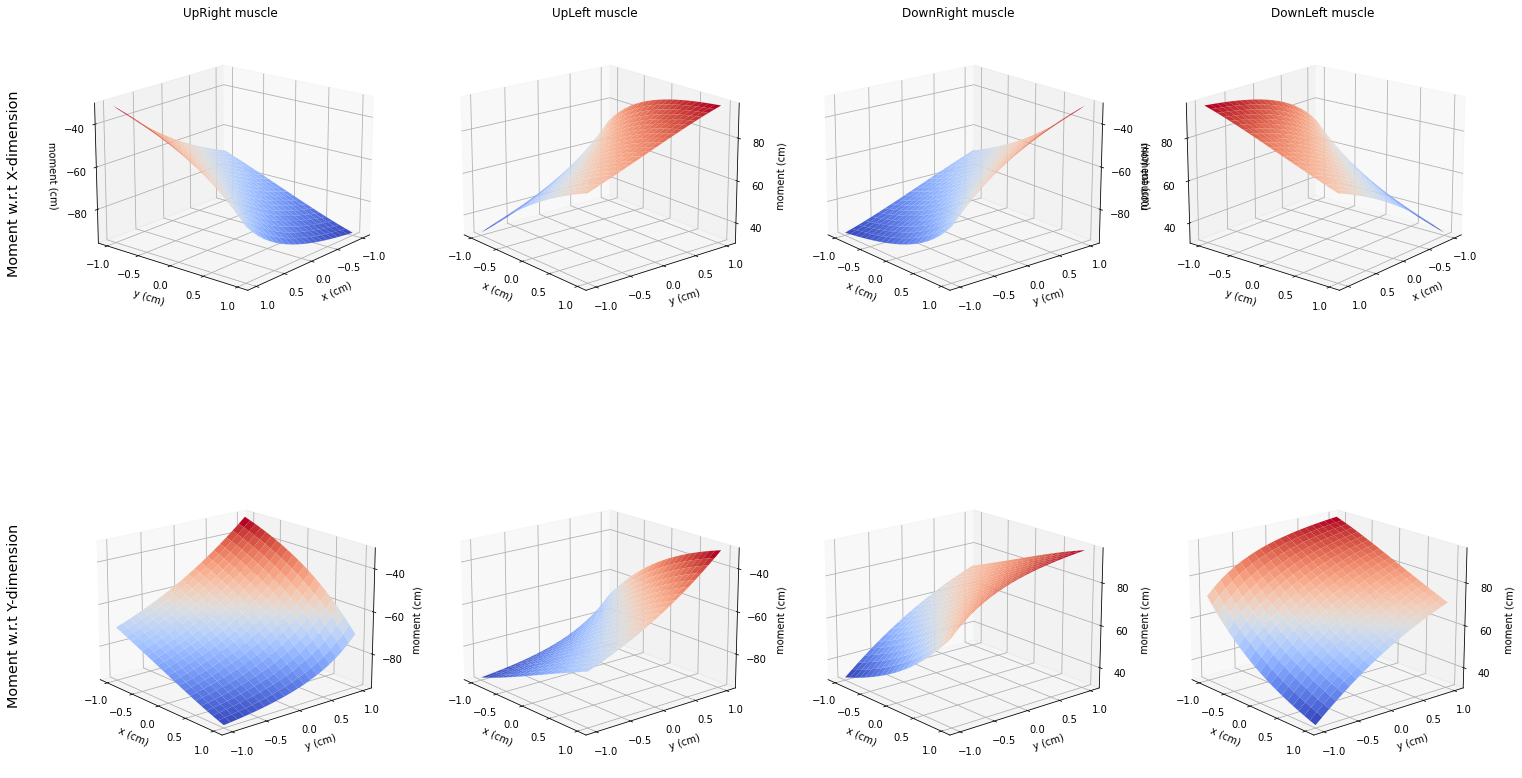

In [4]:

# create initial conditions
n_states = 21  # grid resolution
x, y = np.meshgrid(
    np.linspace(point_mass.pos_lower_bound[0], point_mass.pos_upper_bound[0], n_states).astype('float32'),
    np.linspace(point_mass.pos_lower_bound[1], point_mass.pos_upper_bound[1], n_states).astype('float32'))


# pass the initial joint space to get the full initial states
# The initial state should be a 4-items list containing:
#             [joint_state, cartesian_state, muscle_state, geometry_state]

state0 = point_mass.get_initial_state(joint_state=tf.stack([x.reshape(-1), y.reshape(-1)], axis=1))
mstate = state0[-2].numpy().reshape((n_states, n_states, -1, point_mass.n_muscles))
gstate = state0[-1].numpy().reshape((n_states, n_states, -1, point_mass.n_muscles))


fig = plt.figure()
fig.set_size_inches((25, 15))
# fig.patch.set_facecolor('xkcd:white')

for muscle in range(point_mass.n_muscles):
    for k in range(point_mass.dof):
        subplot = k * point_mass.n_muscles + muscle + 1
        ax = fig.add_subplot(point_mass.dof, point_mass.n_muscles, subplot, projection='3d')

        z = gstate[:, :, 2+k, muscle] * 100  # m to cm
        ax.plot_surface(x, y, z, cmap=plt.get_cmap('coolwarm'))

        ax.set_xlabel('x (cm)')
        ax.set_ylabel('y (cm)')
        ax.set_zlabel('moment (cm)')
        if k == 0:
            ax.set_title(point_mass.muscle_name[muscle] + " muscle")

        # adjust angle of view
        if (muscle==0 or muscle==3) and k == 0:
            ax.view_init(18, 40)
        else:
          ax.view_init(18, -40)
        ax.locator_params(nbins=6)

fig.text(0.085, 0.7, 'Moment w.r.t X-dimension', va='center', rotation='vertical', fontsize='x-large')
fig.text(0.085, 0.3, 'Moment w.r.t Y-dimension', va='center', rotation='vertical', fontsize='x-large')
plt.show()


# II. A more complex plant system: arm210

Now we will create a more complex plant, that uses a 2-DOF arm skeleton and a rigid-tendon Hill muscle.
We then build a muscle system containing 10 muscles inserted in various ways across each bone.

## 1. building the plant
The coordinate system works according to the illustation below. The first coordinate of an insertion point is always in the direction of the bone that point is fixed on, and the second coordinate indicates the deviation perpendicular to that bone's direction.



<img src="img/arm210.png" alt="drawing" width="500"/>


In [75]:


arm210 = mn.plants.Plant(
  skeleton=mn.plants.skeletons.TwoDofArm(),
  muscle_type=mn.plants.muscles.RigidTendonHillMuscleThelen())

arm210.add_muscle(
  path_fixation_body=[0., 1.],
  path_coordinates=[[-.15, .03], [.094, 0.017]],
  name='pectoralis',
  max_isometric_force=838,
  tendon_length=.039,
  optimal_muscle_length=.134,
  normalized_slack_muscle_length=1.48)

arm210.add_muscle(
  path_fixation_body=[0., 1.],
  path_coordinates=[[-.034, .022], [.144, 0.01]],
  name='clavicular deltoid',
  max_isometric_force=680,
  tendon_length=.039,
  optimal_muscle_length=.104,
  normalized_slack_muscle_length=1.4)

arm210.add_muscle(
  path_fixation_body=[0., 0., 1.],
  path_coordinates=[[.14, 0.], [.05, -.00], [0.153, 0.]],
  name='deltoid',
  max_isometric_force=1207,
  tendon_length=.066,
  optimal_muscle_length=.140,
  normalized_slack_muscle_length=1.52)

arm210.add_muscle(
  path_fixation_body=[0., 0., 1.],
  path_coordinates=[[.1, 0.], [.05, -.03], [0.062, 0.004]],
  name='teres major',
  max_isometric_force=1207,
  tendon_length=.066,
  optimal_muscle_length=.068,
  normalized_slack_muscle_length=1.65)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.23, 0.001], [0.231, 0.01]],
  name='brachioradialis',
  max_isometric_force=1422,
  tendon_length=.172,
  optimal_muscle_length=.092,
  normalized_slack_muscle_length=1.43)

arm210.add_muscle(
  path_fixation_body=[1., 1., 2.],
  path_coordinates=[[0.03, 0.], [0.138, -0.019], [-0.04, -0.017]],
  name='tricepslat',
  max_isometric_force=1549,
  tendon_length=.187,
  optimal_muscle_length=.093,
  normalized_slack_muscle_length=1.45)

arm210.add_muscle(
  path_fixation_body=[0., 2.],
  path_coordinates=[[-0.052, 0.033], [0.044, 0.001]],
  name='biceps',
  max_isometric_force=414,
  tendon_length=.204,
  optimal_muscle_length=.137,
  normalized_slack_muscle_length=1.5)

arm210.add_muscle(
  path_fixation_body=[0., 2.],
  path_coordinates=[[0.02, -0.028], [-0.04, -0.017]],
  name='tricepslong',
  max_isometric_force=603,
  tendon_length=0.217,
  optimal_muscle_length=0.127,
  normalized_slack_muscle_length=1.4)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.306, -0.011], [0.003, -0.025]],
  name='anconeus',
  max_isometric_force=300,
  tendon_length=0.01,
  optimal_muscle_length=0.015,
  normalized_slack_muscle_length=1.72)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.277, 0.], [0.075, 0.02]],
  name='prot',
  max_isometric_force=700,
  tendon_length=0.02,
  optimal_muscle_length=0.058,
  normalized_slack_muscle_length=1.48)

print('Plant built.')


Plant built.


In [76]:
arm210.print_muscle_wrappings()

MUSCLE NAME: pectoralis
-----------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-0.15000000596046448, 0.029999999329447746], [0.09399999678134918, 0.017000000923871994]]
max_isometric_force:  838
tendon_length:  0.039
optimal_muscle_length:  0.134
normalized_slack_muscle_length:  1.48


MUSCLE NAME: clavicular deltoid
-------------------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-0.03400000184774399, 0.02199999988079071], [0.14399999380111694, 0.009999999776482582]]
max_isometric_force:  680
tendon_length:  0.039
optimal_muscle_length:  0.104
normalized_slack_muscle_length:  1.4


MUSCLE NAME: deltoid
--------------------
n_fixation_points:  3
fixation body:  [0, 0, 1]
coordinates:  [[0.14000000059604645, 0.0], [0.05000000074505806, -0.0], [0.15299999713897705, 0.0]]
max_isometric_force:  1207
tendon_length:  0.066
optimal_muscle_length:  0.14
normalized_slack_muscle_length:  1.52


MUSCLE NAME: teres major
-------------------

# 2. Visualizing moment arms
Now we can visualize the moment of each muscle with respect to joint angles. Note that there are two surfaces per plot, one for the moment of the shoulder joint and one for the moment of the elbow joint. If a muscle does not span a joint, its moment arm will always be *0* regardless of the skeleton's joint configuration. In other words, if that muscle shortens or lengthens, it would alter the angle of the joint by *0*.


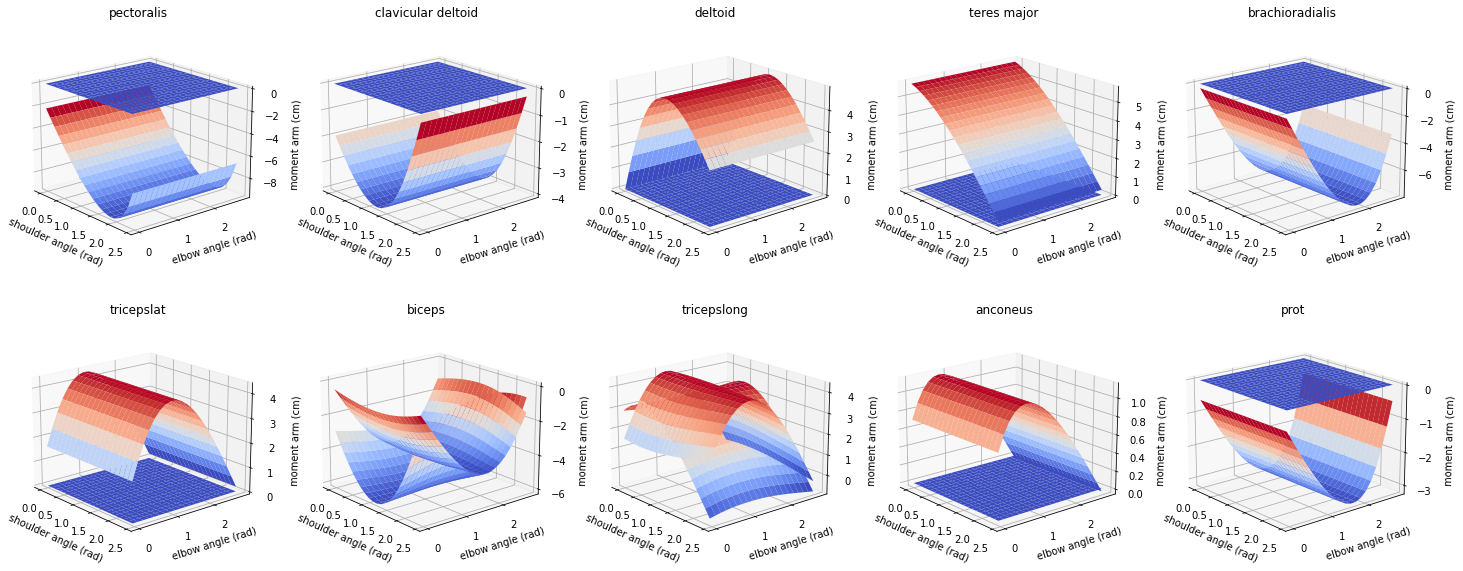

In [6]:

# create a grid of joint angles
n_states = 21  # grid resolution
sho, elb = np.meshgrid(
    np.linspace(arm210.pos_lower_bound[0], arm210.pos_upper_bound[0], n_states).astype('float32'),
    np.linspace(arm210.pos_lower_bound[1], arm210.pos_upper_bound[1], n_states).astype('float32'))

state0 = arm210.get_initial_state(joint_state=tf.stack([sho.reshape(-1), elb.reshape(-1)], axis=1))
mstate = state0[-2].numpy().reshape((n_states, n_states, -1, arm210.n_muscles))
gstate = state0[-1].numpy().reshape((n_states, n_states, -1, arm210.n_muscles))


fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('xkcd:white')
# fig.set_tight_layout(True)
for m in range(arm210.n_muscles):
    ax = fig.add_subplot(2, 5, m+1, projection='3d')
    ax.plot_surface(sho, elb, gstate[:, :, 2, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.plot_surface(sho, elb, gstate[:, :, 3, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('moment arm (cm)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(arm210.muscle_name[m])
plt.show()


## 3. Visualizing muscle lengths
We can also visualize each muscle's length as a function of joint angle.


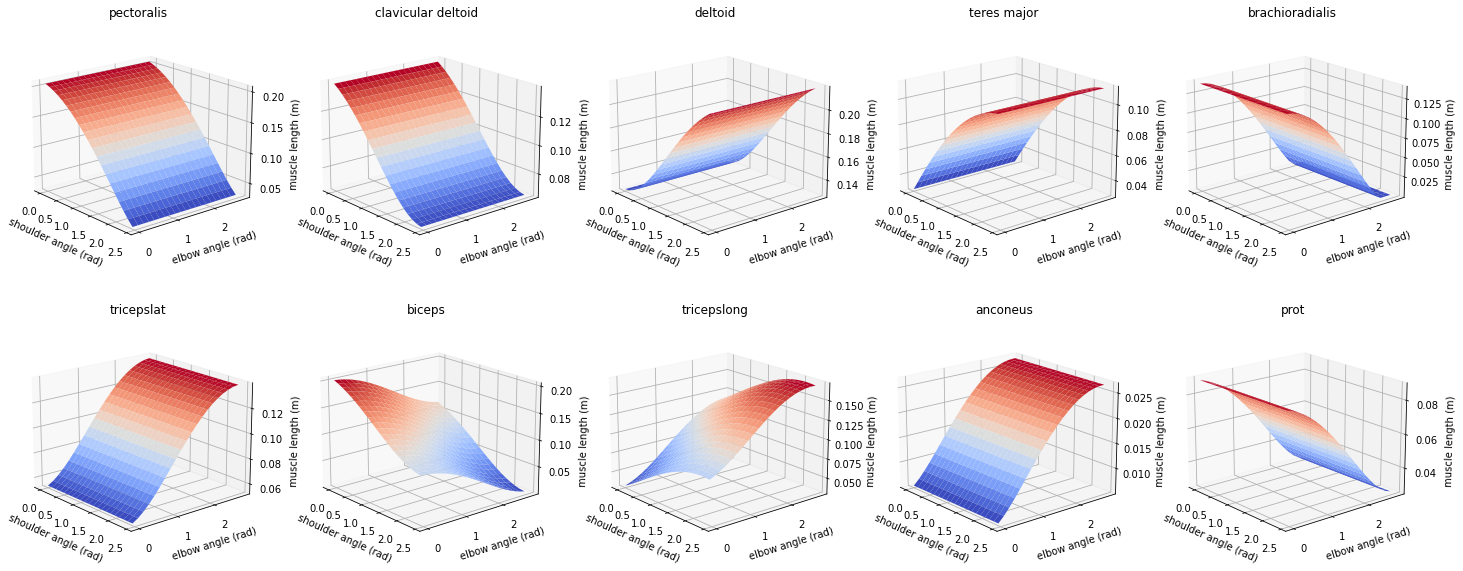

In [7]:

fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('xkcd:white')
# fig.set_tight_layout(True)
for m in range(arm210.n_muscles):
    ax = fig.add_subplot(2, 5, m+1, projection='3d')
    ax.plot_surface(sho, elb, mstate[:, :, 1, m], cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('muscle length (m)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(arm210.muscle_name[m])
plt.show()


# III. Pre-built subclasses

```motornet``` comes with pre-built subclasses for most objects, including ```Plant``` objects. One of those ```Plant``` subclasses is ```RigidTendonArm26```, a 2-DOF, 6-muscles plant that overwrites the default geometry (muscle length, velocity, and moment arm) calculation with its own method. That method approximates muscle length and velocity using a third-degree polynomial approximation function, and assumes linearly varying moment arms. The full-blown model is detailed in [Kistemaker et al., 2006](https://www.physiology.org/doi/10.1152/jn.00983.2005) and [Kistemaker et al., 2010](https://www.physiology.org/doi/10.1152/jn.00483.2010).

## 1. Moment arms and muscle lengths

We can plot muscle lengths and moment arms for the ```RigidTendonArm26``` subclass similar to the previous ```Plant``` examples above to observe that the subclass returns the adjusted geometry properly.


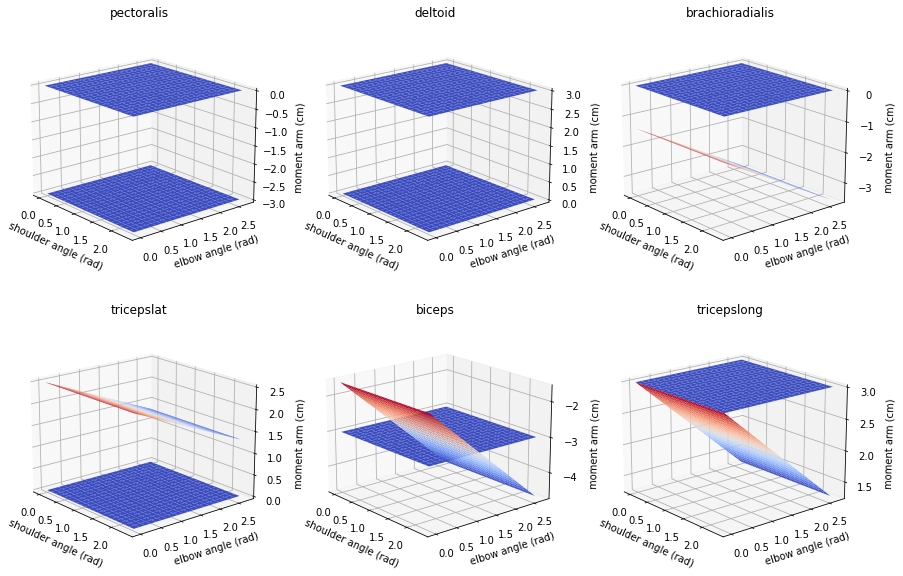

In [8]:

#---------
# create plant instance
#---------
arm26 = mn.plants.RigidTendonArm26(muscle_type=mn.plants.muscles.RigidTendonHillMuscleThelen())


#---------
# get geometry
#---------
sho, elb = np.meshgrid(
  np.linspace(arm26.pos_lower_bound[0], arm26.pos_upper_bound[0], n_states).astype('float32'),
  np.linspace(arm26.pos_lower_bound[1], arm26.pos_upper_bound[1], n_states).astype('float32'))
state0 = arm26.get_initial_state(joint_state=tf.stack([sho.reshape(-1), elb.reshape(-1)], axis=1))
gstate = state0[-1].numpy().reshape((n_states, n_states, -1, arm26.n_muscles))
mstate = state0[-2].numpy().reshape((n_states, n_states, -1, arm26.n_muscles))


#---------
# plot moment arms
#---------
fig = plt.figure(figsize=(15, 10))
# fig.patch.set_facecolor('xkcd:white')
# fig.set_tight_layout(True)
for m in range(arm26.n_muscles):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, gstate[:, :, 2, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.plot_surface(sho, elb, gstate[:, :, 3, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('moment arm (cm)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(arm26.muscle_name[m])
plt.show()


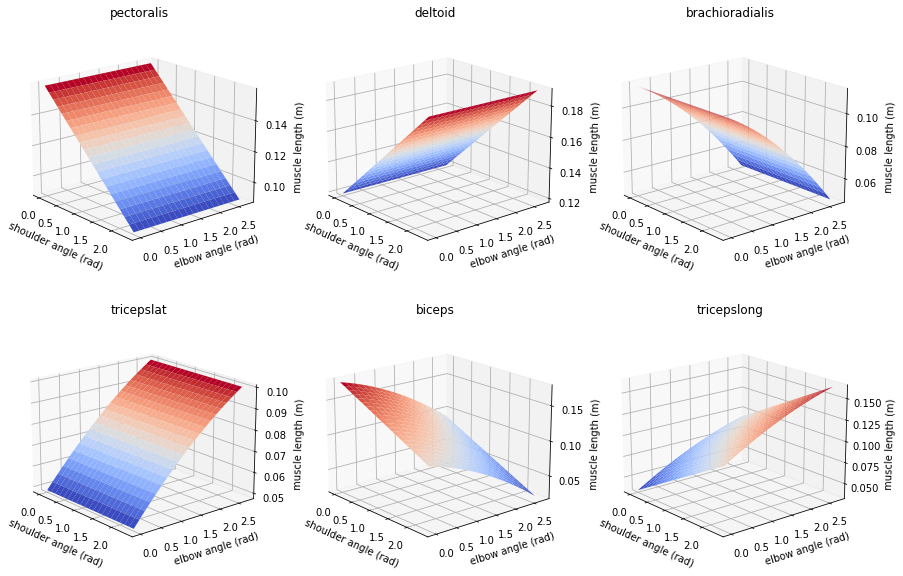

In [9]:

#---------
# plot muscle lengths
#---------
fig = plt.figure(figsize=(15, 10))
# fig.patch.set_facecolor('xkcd:white')
# fig.set_tight_layout(True)
for m in range(arm26.n_muscles):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, mstate[:, :, 1, m], cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('muscle length (m)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(arm26.muscle_name[m])
plt.show()


## 2. Example of drift from passive forces in Hill-type muscles

Hill-type muscles like implemented in ```RigidTendonHillMuscle``` produce passive forces when stretched beyond a certain threshold. This should lead the arm to experience small re-centering forces at the edge of its joint space.
We can observe these forces by running a simulation across the workspace and observe the positional drift in the absence of active input to the plant.


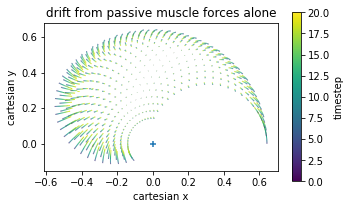

In [10]:

n_states = 21

sho, elb = np.meshgrid(
    np.linspace(arm26.pos_lower_bound[0], arm26.pos_upper_bound[0], n_states).astype('float32'),
    np.linspace(arm26.pos_lower_bound[1], arm26.pos_upper_bound[1], n_states).astype('float32'))
excitation = tf.zeros((sho.size, arm26.n_muscles))


#-------
# 200 ms simulation to assess drift
#-------
states = arm26.get_initial_state(joint_state=tf.stack([sho.reshape(-1), elb.reshape(-1)], axis=1))
c_results = states[1][:, tf.newaxis, :]

for _ in range(int(0.2 / arm26.dt)):
  joint_state, cartesian_state, muscle_state, geometry_state = states
  states = arm26(excitation, joint_state, muscle_state, geometry_state)
  c_results = tf.concat([c_results, states[1][:, tf.newaxis, :]], axis=1)

# plot results
plt.figure(figsize=(5, 3)).set_tight_layout(True)
mn.utils.plotor.plot_pos_over_time(cart_results=c_results)
plt.title('drift from passive muscle forces alone')
plt.show()


# IV. Numerical integration

While muscle and skeleton dynamics are solved via ordinary differential equations (ODEs) held at the level of the `Muscle` and `Skeleton` objects, numerical integration is actually handled by the `Plant` object. This allows integrating both the muscle and skeleton systems at the same time, thereby reducing numerical instability.

The `Plant` object allows for numerical integration via Euler and Runge-Kutta 4 methods, with Euler being the default method.
This is usually sufficient for most simulation work, although some more complex simulations may benefit fro switching to Runge-Kutta 4. It is always recommended to visualize muscle and skeleton dynamics to ensure one's system does not display unstable behaviour.

Below we briefly illustrate the difference between each integration method in the context of `motornet` simulations.

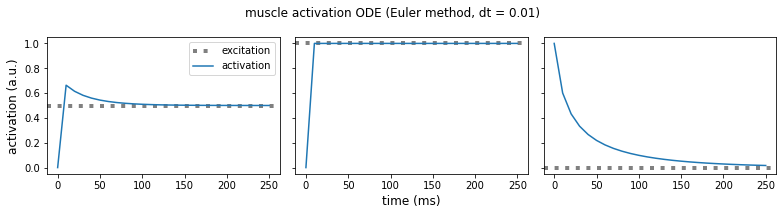

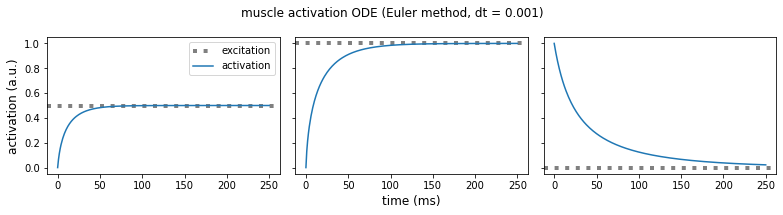

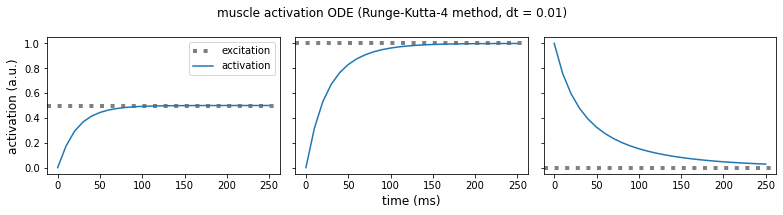

In [64]:
def integrate_activation(plant, excitation_pattern, movement_duration, initial_value):
    t_fn = np.arange(0., movement_duration, plant.dt)

    js, _, ms, gs = plant.get_initial_state(joint_state=tf.zeros((1, 4)))
    ms = tf.concat([tf.ones((1, 1, plant.n_muscles)) * initial_value, ms[:, 1:, :]], axis=1)

    m_states = ms
    inputs = tf.ones((1, plant.n_muscles)) * excitation_pattern

    for _ in range(len(t_fn)):
        js, _, ms, gs = plant(inputs, js, ms, gs)
        m_states = tf.concat([m_states, ms], axis=0)

    return m_states


def plot_integration(plant, title):
  fig, axs = plt.subplots(1, 3, sharey='all', sharex='all')
  fig.set_tight_layout(True)
  fig.set_size_inches((11, 3))

  mvt_dur = 0.25
  xticks = np.linspace(0, mvt_dur, int(mvt_dur / plant.dt)+1) * 1000  # sec to ms

  ms = integrate_activation(plant, [0.5,0,0,0,0,0], mvt_dur, 0)
  axs[0].axhline(0.5, c='grey', ls=':', lw=4, label='excitation')
  axs[0].plot(xticks, ms[:, 0, 0], label='activation')
  axs[0].set_ylabel('activation (a.u.)', fontsize=12)
  axs[0].legend()

  ms = integrate_activation(plant, [1,0,0,0,0,0], mvt_dur, 0)
  axs[1].axhline(1, c='grey', ls=':', lw=4, label='excitation')
  axs[1].plot(xticks, ms[:, 0, 0], label='activation')
  axs[1].set_xlabel('time (ms)', fontsize=12)

  ms = integrate_activation(plant, [0,0,0,0,0,0], mvt_dur, 1)
  axs[2].axhline(0, c='grey', ls=':', lw=4, label='excitation')
  axs[2].plot(xticks, ms[:, 0, 0], label='activation')

  fig.suptitle(title)



muscle_type = mn.plants.muscles.RigidTendonHillMuscleThelen()

arm26 = mn.plants.RigidTendonArm26(muscle_type=muscle_type)
plot_integration(arm26, 'muscle activation ODE (Euler method, dt = 0.01)')

arm26 = mn.plants.RigidTendonArm26(muscle_type=muscle_type, timestep=0.001)
plot_integration(arm26, 'muscle activation ODE (Euler method, dt = 0.001)')

arm26 = mn.plants.RigidTendonArm26(muscle_type=muscle_type, integration_method='rk4')
plot_integration(arm26, 'muscle activation ODE (Runge-Kutta-4 method, dt = 0.01)')

